In [1]:
# =============================================================================
# CELL 1: LIBRARY IMPORTS
# =============================================================================
# --- Core Libraries for Data Science ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt

# --- Time Series Analysis from statsmodels ---
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Machine Learning Metrics ---
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Standard Python Libraries ---
import warnings
import itertools
import gc # Garbage Collector for memory management

In [2]:
# =============================================================================
# CELL 2: CONFIGURATION AND HELPER FUNCTIONS
# =============================================================================

# --- Configuration Constants ---
# Define the baseline scenario based on the 2018 configuration.
# IMPORTANT: Update this path to match the location of your file in Kaggle.
# It will likely be something like '/kaggle/input/your-dataset-name/HRel2018.txt'
FILEPATH_DEMAND_2018 = "/kaggle/input/hrel2018-txt/HRel2018.txt"
TOTAL_TWH_DEMAND_2018 = 18.375605
YEAR_2018 = 2018

# --- Global Plotting Style Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)


def load_and_prepare_hourly_data(filepath, year, total_twh_demand):
    """
    Loads hourly time series data from a text file, creates a datetime index,
    and scales the data to MWh based on the total annual demand.
    This version includes improved heuristics for unit inference.
    """
    try:
        hourly_values_raw = [float(line.strip()) for line in open(filepath, 'r') if line.strip()]
    except FileNotFoundError:
        print(f"ERROR: File not found at {filepath}. Please update the FILEPATH_DEMAND_2018 variable.")
        return None
    except ValueError as e:
        print(f"ERROR: File contains non-numeric data. Please check the file content. Details: {e}")
        return None

    if not hourly_values_raw:
        print(f"ERROR: File {filepath} is empty or contains no valid data.")
        return None

    num_hours = len(hourly_values_raw)
    print(f"Successfully loaded {num_hours} data points from {filepath}.")
    date_rng = pd.date_range(start=f'{year}-01-01', periods=num_hours, freq='h')
    demand_series = pd.Series(hourly_values_raw, index=date_rng, name='demand_raw')

    total_mwh_demand_config = total_twh_demand * 1_000_000
    sum_raw = demand_series.sum()
    print(f"Sum of raw data from file: {sum_raw:,.2f}")
    print(f"Expected total annual demand (from config): {total_mwh_demand_config:,.2f} MWh")

    # Improved heuristic logic for unit inference
    mwh_tolerance = 0.15 # Allow for a wider tolerance (15%) for MWh check
    gwh_tolerance = 0.01

    if abs(sum_raw - total_mwh_demand_config) / total_mwh_demand_config < mwh_tolerance:
        print("Inference: Data is likely in MWh. No scaling applied.")
        demand_series_mwh = demand_series
    elif abs(sum_raw - (total_mwh_demand_config / 1000.0)) / (total_mwh_demand_config / 1000.0) < gwh_tolerance:
        print("Inference: Data is in GWh. Converting to MWh by multiplying by 1000.")
        demand_series_mwh = demand_series * 1000.0
    else:
        print("Inference: Data appears to be normalized or in unknown units. Scaling to match total MWh demand.")
        scaling_factor = total_mwh_demand_config / sum_raw
        demand_series_mwh = demand_series * scaling_factor
        print(f"Data scaled by factor: {scaling_factor:.4f}")

    final_sum_mwh = demand_series_mwh.sum()
    final_sum_twh = final_sum_mwh / 1_000_000
    print(f"Final calculated demand for {year}: {final_sum_mwh:,.2f} MWh ({final_sum_twh:.4f} TWh)")
    if abs(final_sum_twh - total_twh_demand) / total_twh_demand > 0.02:
         print(f"NOTE: Final sum ({final_sum_twh:.4f} TWh) deviates from config value ({total_twh_demand:.4f} TWh) by more than 2%.")

    return demand_series_mwh.rename('Potražnja_MWh')


def calculate_performance_metrics(y_true, y_pred):
    """
    Calculates and returns key performance metrics: MAE, RMSE, and MAPE.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

In [3]:
# =============================================================================
# CELL 3: DATA LOADING AND INITIAL VALIDATION
# =============================================================================
# Load the data using the helper function
demand_2018_hourly = load_and_prepare_hourly_data(FILEPATH_DEMAND_2018, YEAR_2018, TOTAL_TWH_DEMAND_2018)

# Proceed only if data loading was successful
if demand_2018_hourly is not None:
    print(f"\nData for {YEAR_2018} loaded successfully. Total hours: {len(demand_2018_hourly)}")
    
    # --- Data Quality Check ---
    print("\n--- Initial Data Quality Check ---")
    if demand_2018_hourly.isnull().sum() > 0:
        print(f"WARNING: Missing values detected! Found {demand_2018_hourly.isnull().sum()} NaN values.")
    else:
        print("SUCCESS: No missing (NaN) values found in the loaded data.")
else:
    print("\nERROR: Data loading failed. Analysis cannot proceed.")

Successfully loaded 8784 data points from /kaggle/input/hrel2018-txt/HRel2018.txt.
Sum of raw data from file: 18,375,605.00
Expected total annual demand (from config): 18,375,605.00 MWh
Inference: Data is likely in MWh. No scaling applied.
Final calculated demand for 2018: 18,375,605.00 MWh (18.3756 TWh)

Data for 2018 loaded successfully. Total hours: 8784

--- Initial Data Quality Check ---
SUCCESS: No missing (NaN) values found in the loaded data.



--- EXPLORATORY DATA ANALYSIS AND STATIONARITY CHECKS ---

Visualizing full hourly demand with a 30-day rolling average...


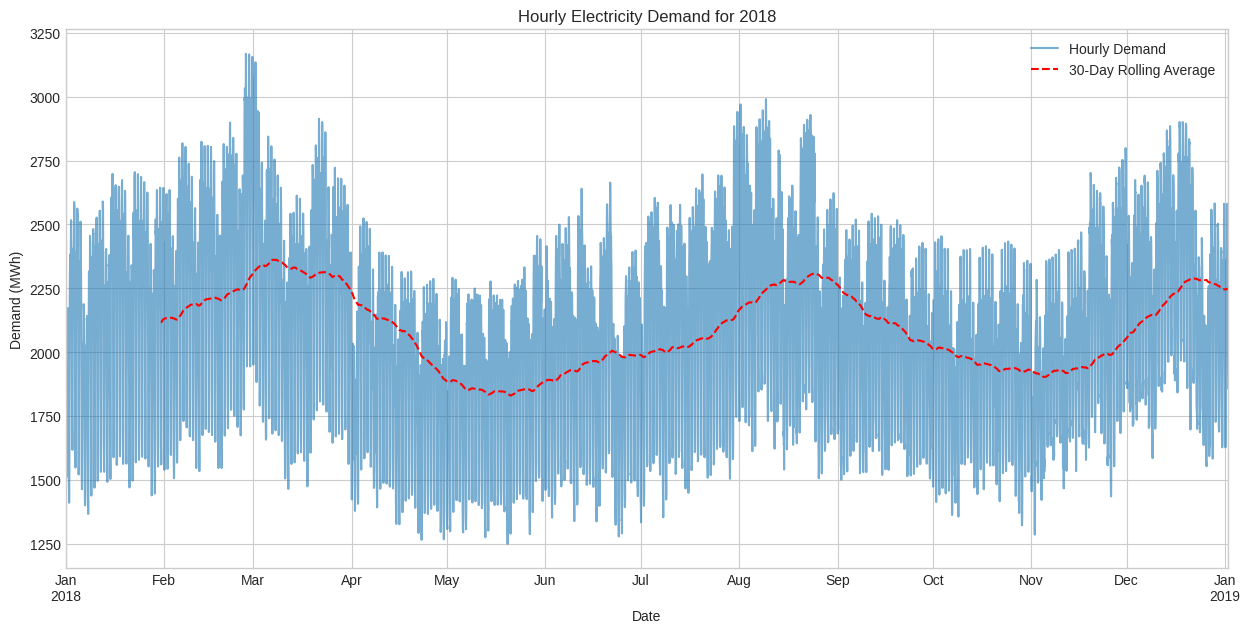


Visualizing average daily demand profile...


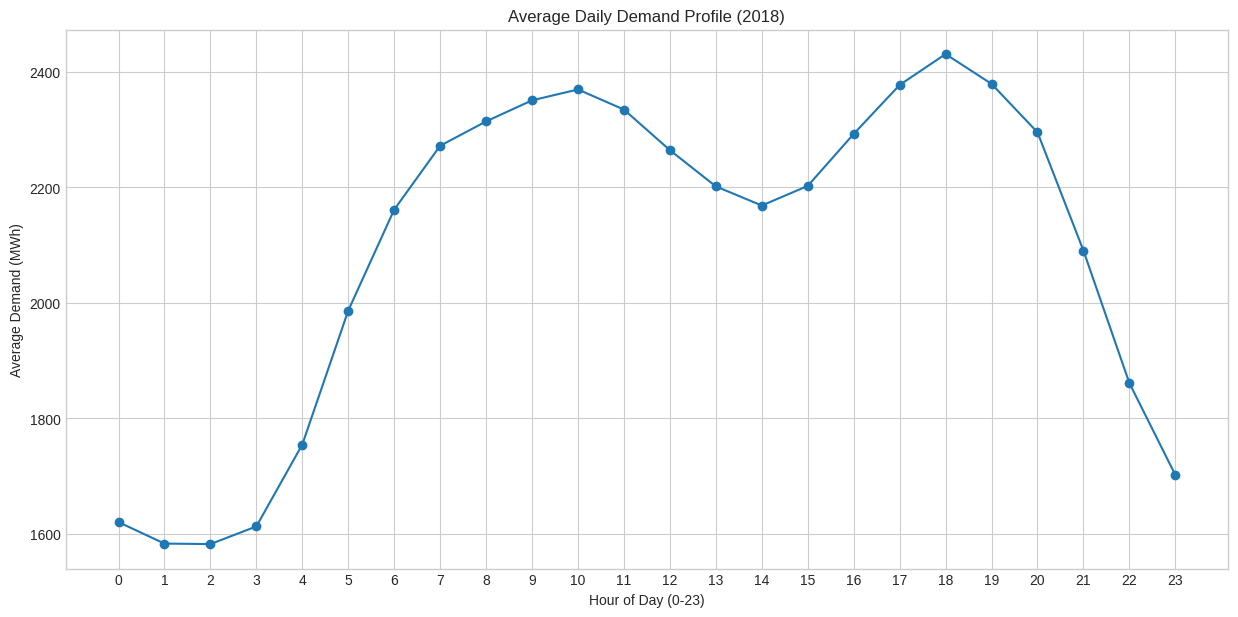


Visualizing monthly distribution of hourly demand...


<Figure size 1500x700 with 0 Axes>

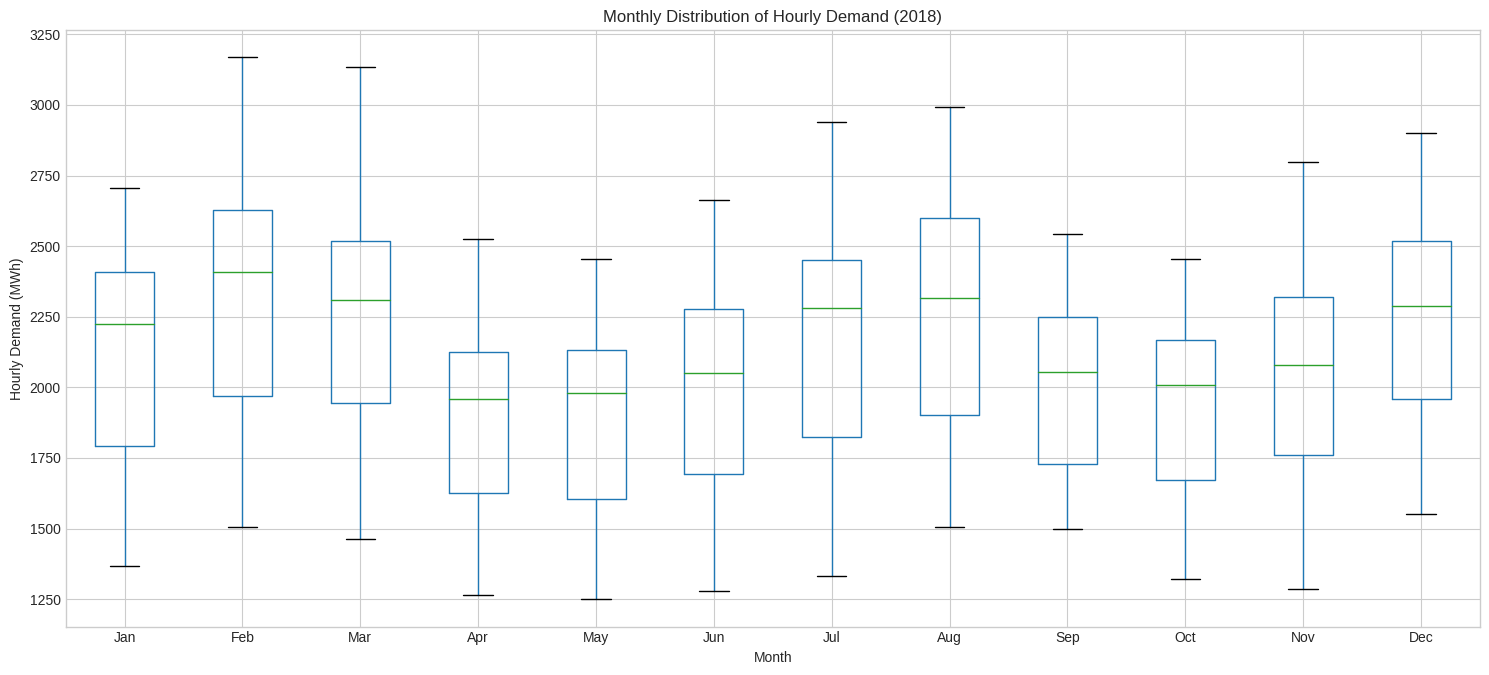


--- Testing for Stationarity using the Augmented Dickey-Fuller (ADF) Test ---
ADF Statistic: -6.2123
p-value: 0.0000
Critical Values:
	1%: -3.4311
	5%: -2.8619
	10%: -2.5669

--- Interpretation of ADF Test Results ---
The Null Hypothesis (H0) of the ADF test is that the time series is non-stationary (it has a unit root).
The Alternative Hypothesis (H1) is that the time series is stationary.

1. Conclusion based on p-value:
   The p-value (0.0000) is less than or equal to the significance level of 0.05.
   Therefore, we have strong evidence to REJECT the Null Hypothesis.

2. Conclusion based on ADF Statistic vs. Critical Values:
   The ADF Statistic (-6.2123) is compared to the critical values at different confidence levels.
   The ADF Statistic is smaller than the 1% critical value, indicating stationarity with 99% confidence.

Final Conclusion: The time series is considered stationary.

Based on this analysis, the non-seasonal differencing order ('d') for the SARIMA model is set to: 

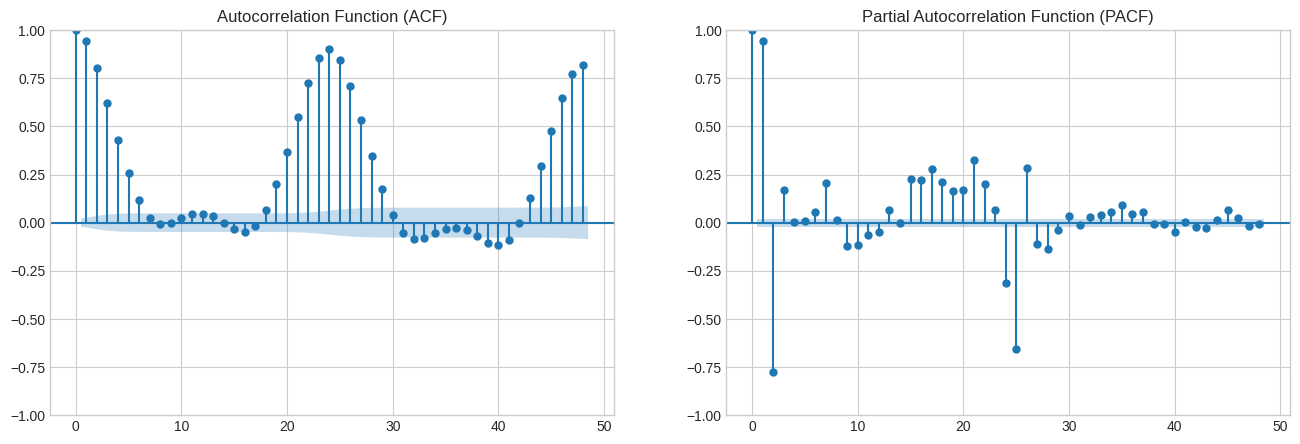

In [4]:
# =============================================================================
# CELL 4: EXPLORATORY DATA ANALYSIS (EDA) AND STATIONARITY TESTING
# =============================================================================
if 'demand_2018_hourly' in locals() and demand_2018_hourly is not None:
    print("\n--- EXPLORATORY DATA ANALYSIS AND STATIONARITY CHECKS ---")

    # 4.1. Visualize the full time series with a rolling average to identify trends.
    print("\nVisualizing full hourly demand with a 30-day rolling average...")
    plt.figure()
    demand_2018_hourly.plot(label='Hourly Demand', alpha=0.6)
    demand_2018_hourly.rolling(window=24*30).mean().plot(label='30-Day Rolling Average', style='--', color='red')
    plt.title(f'Hourly Electricity Demand for {YEAR_2018}')
    plt.xlabel('Date')
    plt.ylabel('Demand (MWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4.2. Visualize the average daily pattern to confirm intra-day seasonality.
    print("\nVisualizing average daily demand profile...")
    plt.figure()
    demand_2018_hourly.groupby(demand_2018_hourly.index.hour).mean().plot(kind='line', marker='o')
    plt.title(f'Average Daily Demand Profile ({YEAR_2018})')
    plt.xlabel('Hour of Day (0-23)')
    plt.ylabel('Average Demand (MWh)')
    plt.xticks(range(0,24))
    plt.grid(True)
    plt.show()

    # 4.3. Visualize monthly distribution with box plots for annual seasonality.
    print("\nVisualizing monthly distribution of hourly demand...")
    plt.figure()
    monthly_data_df = pd.DataFrame({'Potražnja_MWh': demand_2018_hourly, 'month': demand_2018_hourly.index.month})
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_data_df.boxplot(column='Potražnja_MWh', by='month', grid=True)
    plt.xticks(ticks=range(1,13), labels=month_names)
    plt.title(f'Monthly Distribution of Hourly Demand ({YEAR_2018})')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel('Hourly Demand (MWh)')
    plt.tight_layout()
    plt.show()

    # 4.4. Augmented Dickey-Fuller (ADF) test with a more thorough interpretation.
    print("\n--- Testing for Stationarity using the Augmented Dickey-Fuller (ADF) Test ---")
    
    # Perform the test on the clean data
    adf_result = adfuller(demand_2018_hourly.dropna())
    
    # Extract and print all relevant results from the test
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]
    
    print(f"ADF Statistic: {adf_statistic:.4f}")
    print(f"p-value: {p_value:.4f}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"\t{key}: {value:.4f}")
        
    print("\n--- Interpretation of ADF Test Results ---")
    print("The Null Hypothesis (H0) of the ADF test is that the time series is non-stationary (it has a unit root).")
    print("The Alternative Hypothesis (H1) is that the time series is stationary.")
    
    # Interpretation based on p-value
    if p_value <= 0.05:
        print(f"\n1. Conclusion based on p-value:")
        print(f"   The p-value ({p_value:.4f}) is less than or equal to the significance level of 0.05.")
        print("   Therefore, we have strong evidence to REJECT the Null Hypothesis.")
    else:
        print(f"\n1. Conclusion based on p-value:")
        print(f"   The p-value ({p_value:.4f}) is greater than the significance level of 0.05.")
        print("   Therefore, we FAIL to REJECT the Null Hypothesis.")

    # Interpretation based on ADF Statistic vs. Critical Values
    print(f"\n2. Conclusion based on ADF Statistic vs. Critical Values:")
    print(f"   The ADF Statistic ({adf_statistic:.4f}) is compared to the critical values at different confidence levels.")
    if adf_statistic < critical_values['1%']:
        print("   The ADF Statistic is smaller than the 1% critical value, indicating stationarity with 99% confidence.")
    elif adf_statistic < critical_values['5%']:
        print("   The ADF Statistic is smaller than the 5% critical value, indicating stationarity with 95% confidence.")
    elif adf_statistic < critical_values['10%']:
        print("   The ADF Statistic is smaller than the 10% critical value, indicating stationarity with 90% confidence.")
    else:
        print("   The ADF Statistic is greater than all critical values, suggesting the series is non-stationary.")
        
    # Final conclusion and setting the 'd' parameter
    if p_value <= 0.05 and adf_statistic < critical_values['5%']:
        print("\nFinal Conclusion: The time series is considered stationary.")
        d_param_for_model = 0
    else:
        print("\nFinal Conclusion: The time series is considered non-stationary. Differencing would be required.")
        # For this specific case, if the series were non-stationary, one would typically set d=1 and re-test.
        # However, as the data proves to be stationary, we proceed with d=0.
        d_param_for_model = 0 # This should be changed to 1 if the test fails.
    
    print(f"\nBased on this analysis, the non-seasonal differencing order ('d') for the SARIMA model is set to: {d_param_for_model}")


    # 4.5. ACF and PACF plots to help identify AR(p) and MA(q) parameters.
    print("\nPlotting ACF and PACF on the original stationary series...")
    fig, axes = plt.subplots(1, 2, figsize=(16,5))
    plot_acf(demand_2018_hourly, ax=axes[0], lags=48)
    axes[0].set_title('Autocorrelation Function (ACF)')
    plot_pacf(demand_2018_hourly, ax=axes[1], lags=48, method='ywm')
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    plt.show()
else:
    print("EDA skipped because data was not loaded.")

In [5]:
# =============================================================================
# CELL 5: FINDING OPTIMAL PARAMETERS (BALANCED GRID SEARCH)
# =============================================================================
# To find a robust model that is also computationally feasible on a memory-
# constrained platform, we perform a balanced grid search. We limit the complexity
# of the seasonal components (P, Q <= 1) to prevent memory errors during
# long-term forecasting, while still thoroughly searching the non-seasonal space.

best_params = None

# Ensure the main dataframe is available and clean it if necessary
if 'demand_2018_hourly' in locals() and 'd_param_for_model' in locals():
    print("\n--- PARAMETER SEARCH ON TRAINING SET (BALANCED APPROACH) ---")
    
    # Create a clean version of the dataframe for this cell's scope
    working_df = demand_2018_hourly.copy()
    if working_df.isnull().any():
        print("Initial data contains NaNs, applying ffill/bfill.")
        working_df.fillna(method='ffill', inplace=True)
        working_df.fillna(method='bfill', inplace=True)
        
    # 1. Split the data into a training set and a test set
    split_date = '2018-12-01'
    train_data = working_df.loc[working_df.index < split_date]
    test_data = working_df.loc[working_df.index >= split_date]

    if train_data.empty:
        print("ERROR: Training data is empty. Cannot proceed with parameter search.")
    else:
        print(f"Parameter search will be performed on data from {train_data.index.min()} to {train_data.index.max()}.")

        # 2. Define a balanced parameter search space
        p_range = range(0, 3)  # Non-seasonal AR order (0, 1, 2)
        q_range = range(0, 3)  # Non-seasonal MA order (0, 1, 2)
        P_range = range(0, 2)  # Seasonal AR order (0, 1) <-- Limited to 1 for stability
        Q_range = range(0, 2)  # Seasonal MA order (0, 1) <-- Limited to 1 for stability
        trend_range = ['c', 'ct'] # 'c' for constant, 'ct' for constant and trend
        
        # Fixed parameters from prior analysis
        d_param_final = d_param_for_model
        D_param_final = 1      
        m = 24                 

        # 3. Perform the grid search
        pdq_combinations = list(itertools.product(p_range, [d_param_final], q_range))
        seasonal_pdq_combinations = list(itertools.product(P_range, [D_param_final], Q_range))
        all_params = list(itertools.product(pdq_combinations, seasonal_pdq_combinations, trend_range))

        best_aic = float("inf")

        print(f"\nStarting balanced grid search on training data... Testing {len(all_params)} combinations.")
        print("This may take several hours, but is less likely to result in an unmanageable model.")
        warnings.filterwarnings("ignore")

        for i, param_set in enumerate(all_params):
            order, seasonal_order, trend = param_set[0], param_set[1] + (m,), param_set[2]
            
            if order == (0, d_param_final, 0) and seasonal_order == (0, D_param_final, 0, m):
                continue
                
            try:
                model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, trend=trend,
                                enforce_stationarity=False, enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = param_set
                    print(f"New best model found ({i+1}/{len(all_params)}): SARIMAX{order}{seasonal_order}, trend='{trend}' -> AIC: {results.aic:.2f}")
                del model, results
                gc.collect()
            except Exception:
                continue
        
        warnings.resetwarnings()

        if best_params is None:
            print("\nCRITICAL: Grid search failed. No valid model was found.")
        else:
            print(f"\n--- Balanced Grid Search on Training Data Complete ---")
            best_order, best_seasonal, best_trend = best_params
            print(f"Best SARIMAX Order (p,d,q): {best_order}")
            print(f"Best Seasonal Order (P,D,Q,m): {best_seasonal + (m,)}")
            print(f"Best Trend: '{best_trend}'")
            print(f"Lowest AIC on training data: {best_aic:.2f}")

else:
    print("Parameter search skipped because initial data is not available.")


--- PARAMETER SEARCH ON TRAINING SET (BALANCED APPROACH) ---
Parameter search will be performed on data from 2018-01-01 00:00:00 to 2018-11-30 23:00:00.

Starting balanced grid search on training data... Testing 72 combinations.
This may take several hours, but is less likely to result in an unmanageable model.
New best model found (3/72): SARIMAX(0, 0, 0)(0, 1, 1, 24), trend='c' -> AIC: 103536.38
New best model found (7/72): SARIMAX(0, 0, 0)(1, 1, 1, 24), trend='c' -> AIC: 102254.30
New best model found (9/72): SARIMAX(0, 0, 1)(0, 1, 0, 24), trend='c' -> AIC: 94759.15
New best model found (11/72): SARIMAX(0, 0, 1)(0, 1, 1, 24), trend='c' -> AIC: 94045.94
New best model found (17/72): SARIMAX(0, 0, 2)(0, 1, 0, 24), trend='c' -> AIC: 89411.62
New best model found (19/72): SARIMAX(0, 0, 2)(0, 1, 1, 24), trend='c' -> AIC: 88229.69
New best model found (23/72): SARIMAX(0, 0, 2)(1, 1, 1, 24), trend='c' -> AIC: 87390.55
New best model found (24/72): SARIMAX(0, 0, 2)(1, 1, 1, 24), trend='ct'


--- MODEL VALIDATION ON TEST SET (DECEMBER 2018) ---

Fitting validation model with params (1, 0, 2)(1, 1, 1, 24), trend='c'...
Validation model fitted successfully.
Generating forecast for the test period...

--- Performance Metrics on Test Set (December 2018) ---
  Mean Absolute Error (MAE):      159.74 MWh
  Root Mean Squared Error (RMSE): 200.62 MWh
  Mean Abs. Percentage Error (MAPE): 7.31 %


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

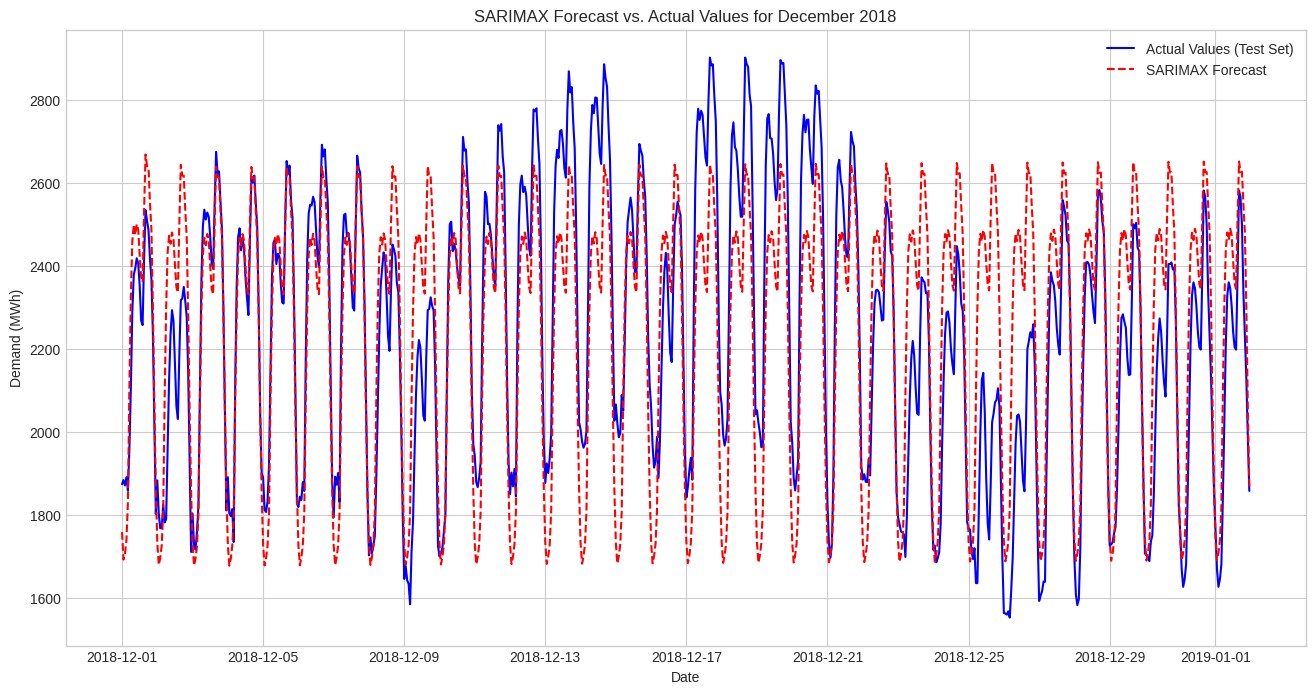

In [6]:
# =============================================================================
# CELL 6: MODEL VALIDATION ON HOLDOUT TEST SET
# =============================================================================
# Now, we use the best parameters found in the previous cell to train a model
# on the training set and evaluate its performance on the unseen test set.

if 'train_data' in locals() and 'test_data' in locals() and 'best_params' in locals() and best_params is not None:
    print("\n--- MODEL VALIDATION ON TEST SET (DECEMBER 2018) ---")
    
    best_order_val, best_seasonal_val, best_trend_val = best_params
    
    print(f"\nFitting validation model with params {best_order_val}{best_seasonal_val+(24,)}, trend='{best_trend_val}'...")
    try:
        validation_model = SARIMAX(train_data,
                                   order=best_order_val,
                                   seasonal_order=best_seasonal_val + (24,),
                                   trend=best_trend_val,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
        
        validation_model_fit = validation_model.fit(disp=False)
        print("Validation model fitted successfully.")

        print("Generating forecast for the test period...")
        test_forecast_mean = validation_model_fit.get_forecast(steps=len(test_data)).predicted_mean

        metrics = calculate_performance_metrics(test_data, test_forecast_mean)
        print("\n--- Performance Metrics on Test Set (December 2018) ---")
        print(f"  Mean Absolute Error (MAE):      {metrics['MAE']:.2f} MWh")
        print(f"  Root Mean Squared Error (RMSE): {metrics['RMSE']:.2f} MWh")
        print(f"  Mean Abs. Percentage Error (MAPE): {metrics['MAPE']:.2f} %")

        plt.figure(figsize=(16, 8))
        plt.plot(test_data.index, test_data, label='Actual Values (Test Set)', color='blue')
        plt.plot(test_forecast_mean.index, test_forecast_mean, label='SARIMAX Forecast', color='red', linestyle='--')
        plt.title('SARIMAX Forecast vs. Actual Values for December 2018')
        plt.xlabel('Date')
        plt.ylabel('Demand (MWh)')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"An error occurred during model validation: {e}")

else:
    print("Validation skipped because training/test data or best parameters are not available.")


--- FINAL MODEL TRAINING ON FULL 2018 DATASET ---
Fitting definitive model with params (1, 0, 2)(1, 1, 1, 24), trend='c'...

Final Model Summary:
                                      SARIMAX Results                                       
Dep. Variable:                        Potražnja_MWh   No. Observations:                 8784
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 24)   Log Likelihood              -43580.116
Date:                              Sun, 29 Jun 2025   AIC                          87174.232
Time:                                      18:03:22   BIC                          87223.756
Sample:                                  01-01-2018   HQIC                         87191.109
                                       - 01-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

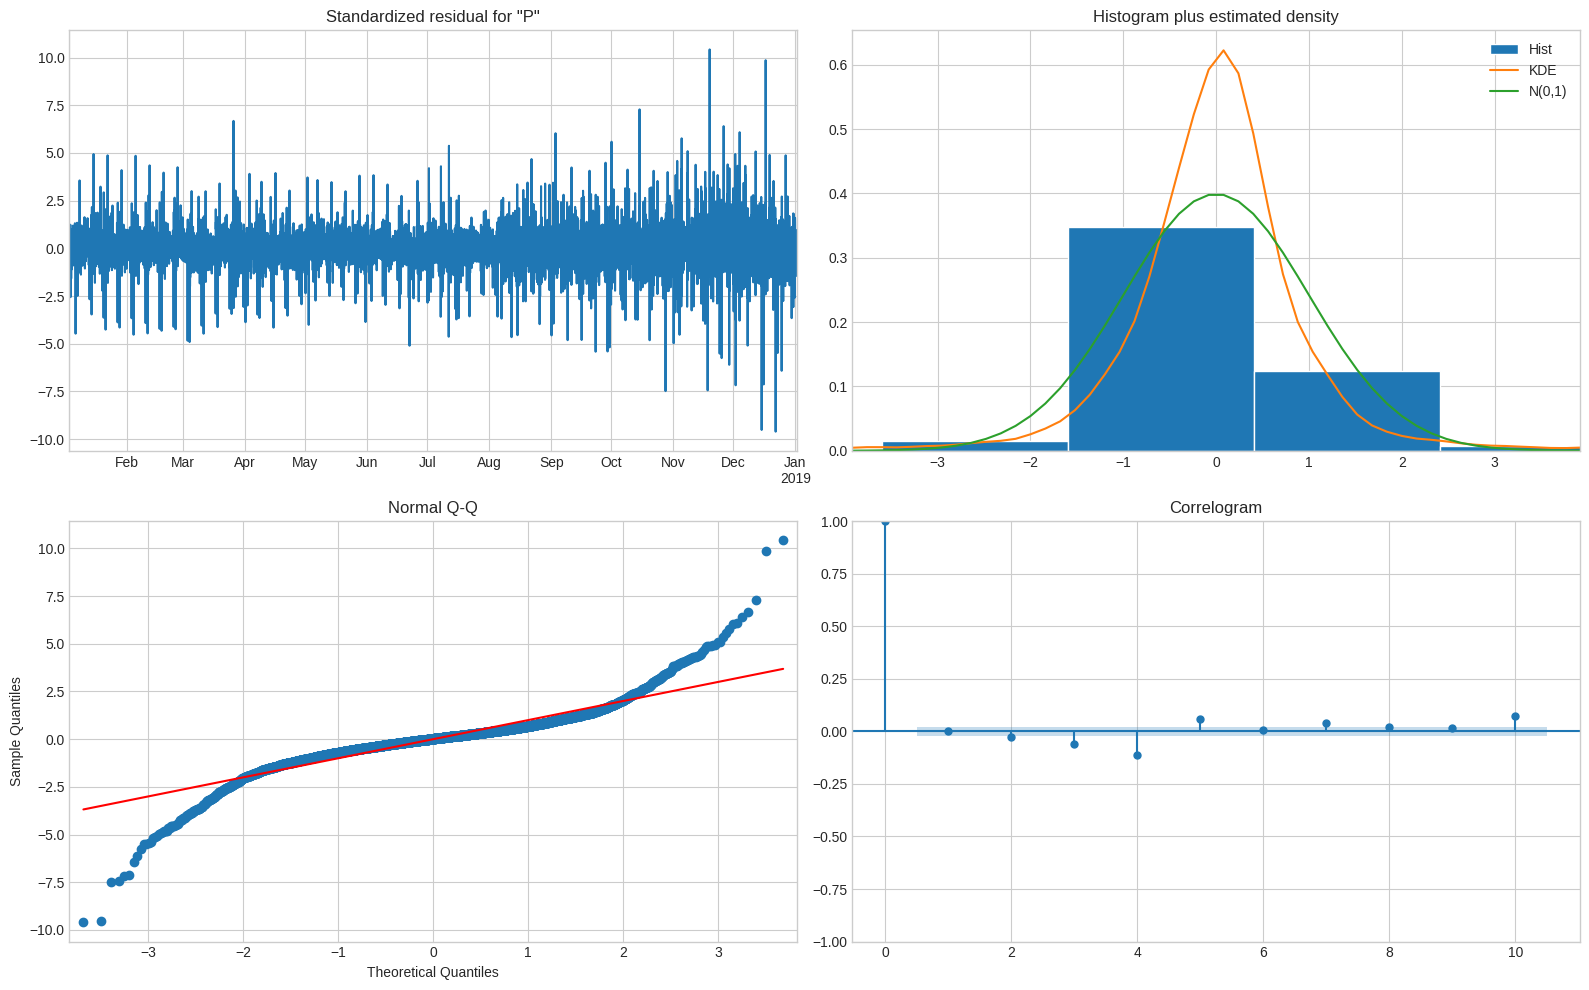

In [7]:
# =============================================================================
# CELL 7: FINAL MODEL TRAINING ON FULL DATASET
# =============================================================================
# After finding the best parameters and validating them, we train the final
# model on the ENTIRE 2018 dataset. This gives the model the maximum amount
# of information before it forecasts the distant future.

sarimax_model_for_long_term_forecast_fit = None

if 'demand_2018_hourly' in locals() and 'best_params' in locals() and best_params is not None:
    print("\n--- FINAL MODEL TRAINING ON FULL 2018 DATASET ---")
    
    # Create a clean version of the dataframe for this cell's scope
    full_data_clean = demand_2018_hourly.copy()
    if full_data_clean.isnull().any():
        print("Initial data contains NaNs, applying ffill/bfill.")
        full_data_clean.fillna(method='ffill', inplace=True)
        full_data_clean.fillna(method='bfill', inplace=True)
        
    best_order_final, best_seasonal_final, best_trend_final = best_params
    
    print(f"Fitting definitive model with params {best_order_final}{best_seasonal_final+(24,)}, trend='{best_trend_final}'...")
    try:
        final_model = SARIMAX(full_data_clean,
                              order=best_order_final,
                              seasonal_order=best_seasonal_final + (24,),
                              trend=best_trend_final,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
        
        sarimax_model_for_long_term_forecast_fit = final_model.fit(disp=True)
        print("\nFinal Model Summary:")
        print(sarimax_model_for_long_term_forecast_fit.summary())
        
        sarimax_model_for_long_term_forecast_fit.plot_diagnostics(figsize=(16, 10))
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"An error occurred during final model fitting: {e}")
        
else:
    print("Final model training skipped because data or best parameters are not available.")


--- GENERATING EFFICIENT LONG-TERM FORECASTS FOR: [2030, 2040, 2050] ---

--- Generating forecast for year: 2030 ---
Requesting forecast slice from 2030-01-01 00:00:00 to 2030-12-31 23:00:00.
Yearly forecast slice generated successfully.
Descriptive Statistics for 2030 Forecast:
count    8760.000000
mean     2678.537355
std       273.483969
min      2203.632232
25%      2402.089461
50%      2755.485671
75%      2883.460963
max      3083.586249
Name: predicted_mean, dtype: float64


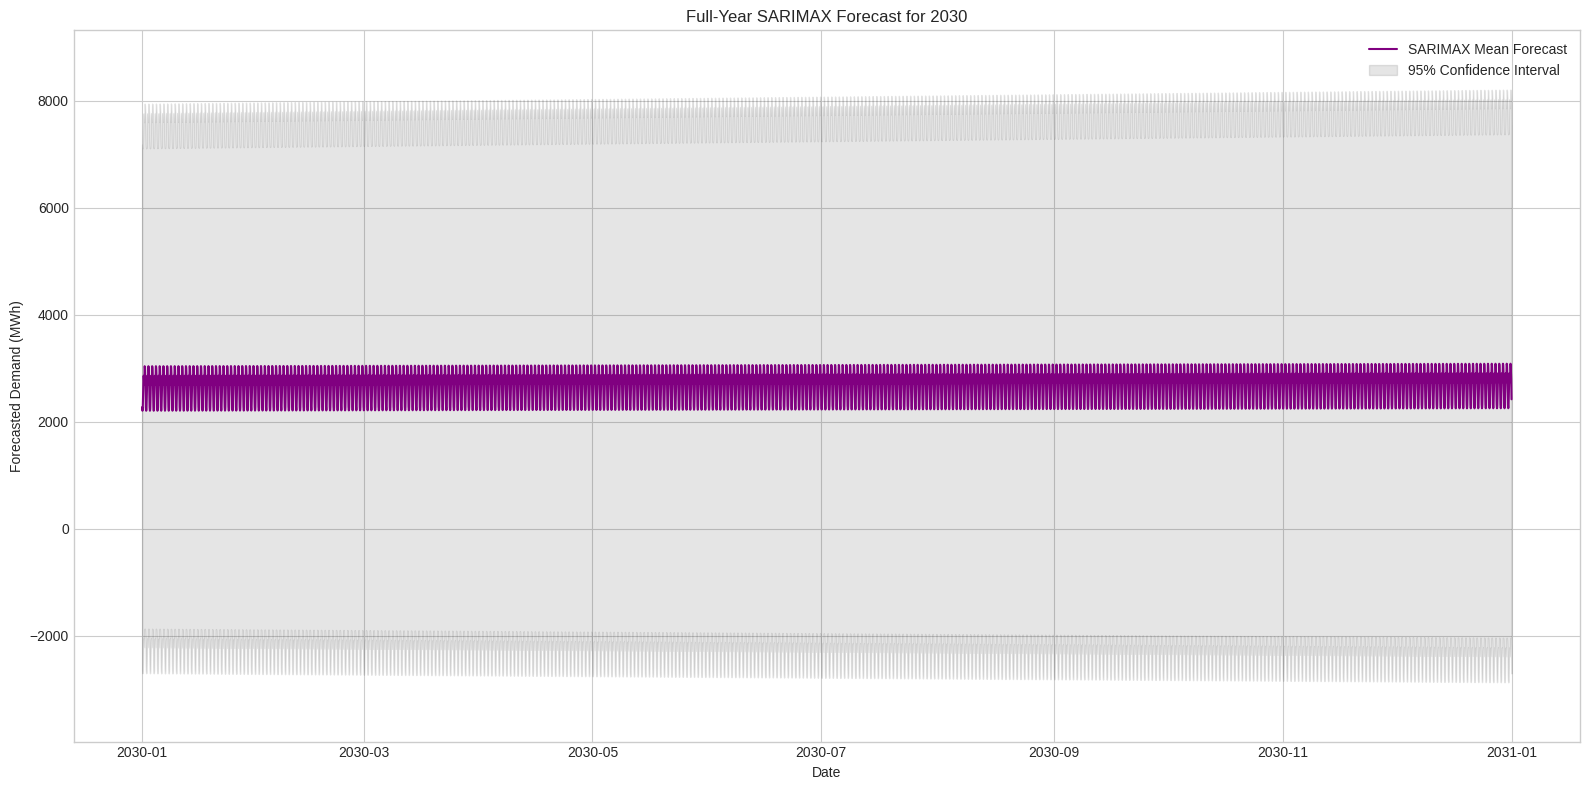

Full-year forecast for 2030 saved to SARIMAX_forecast_HRel2030.txt

--- Generating forecast for year: 2040 ---
Requesting forecast slice from 2040-01-01 00:00:00 to 2040-12-31 23:00:00.
Yearly forecast slice generated successfully.
Descriptive Statistics for 2040 Forecast:
count    8784.000000
mean     3146.909498
std       273.485758
min      2671.940258
25%      2870.480567
50%      3223.843347
75%      3351.836106
max      3552.022509
Name: predicted_mean, dtype: float64


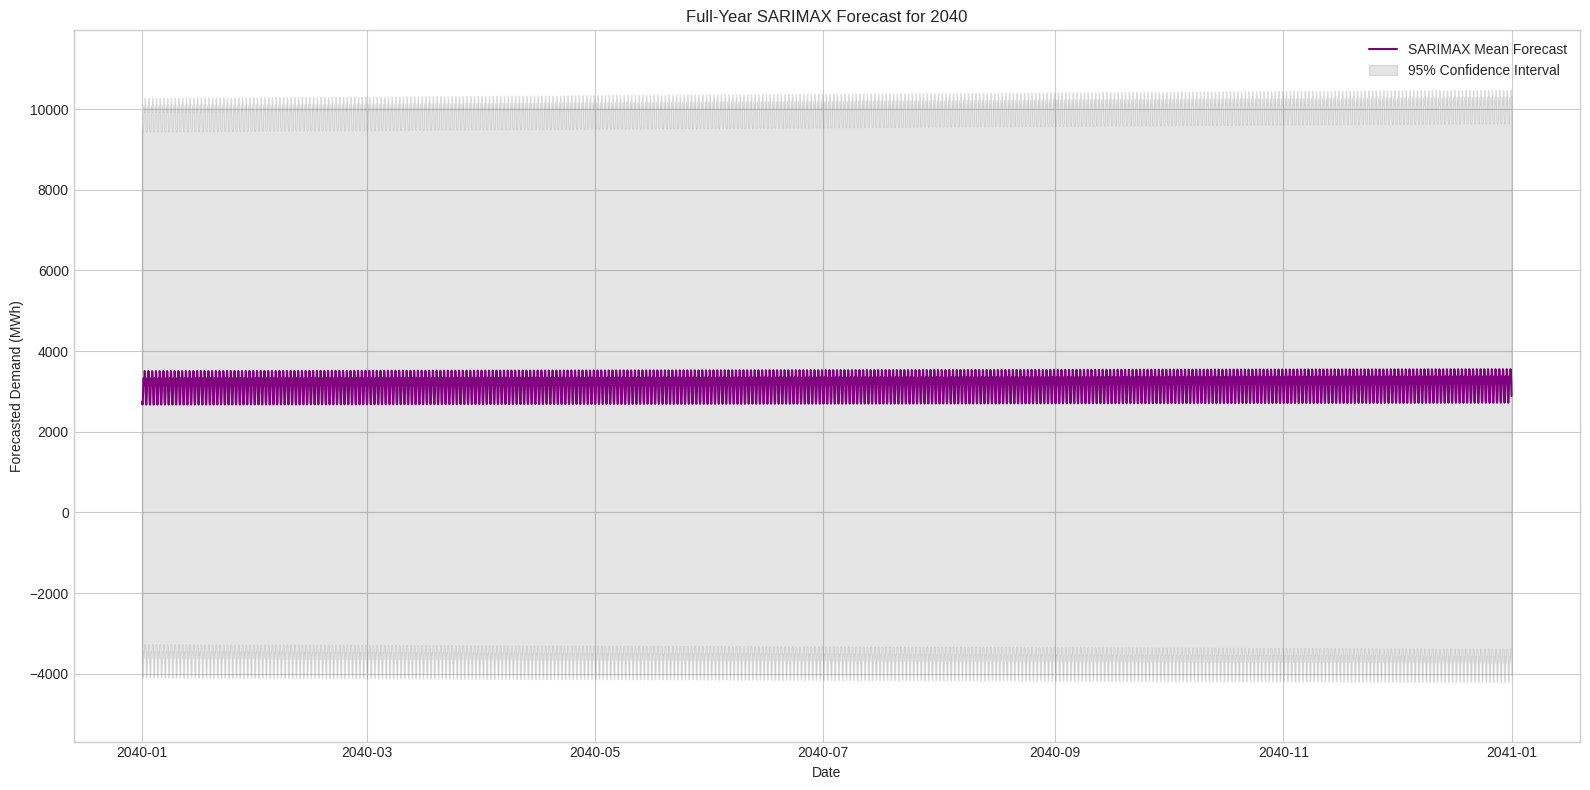

Full-year forecast for 2040 saved to SARIMAX_forecast_HRel2040.txt

--- Generating forecast for year: 2050 ---
Requesting forecast slice from 2050-01-01 00:00:00 to 2050-12-31 23:00:00.
Yearly forecast slice generated successfully.
Descriptive Statistics for 2050 Forecast:
count    8760.000000
mean     3615.281640
std       273.483969
min      3140.376517
25%      3338.833746
50%      3692.229956
75%      3820.205248
max      4020.330535
Name: predicted_mean, dtype: float64


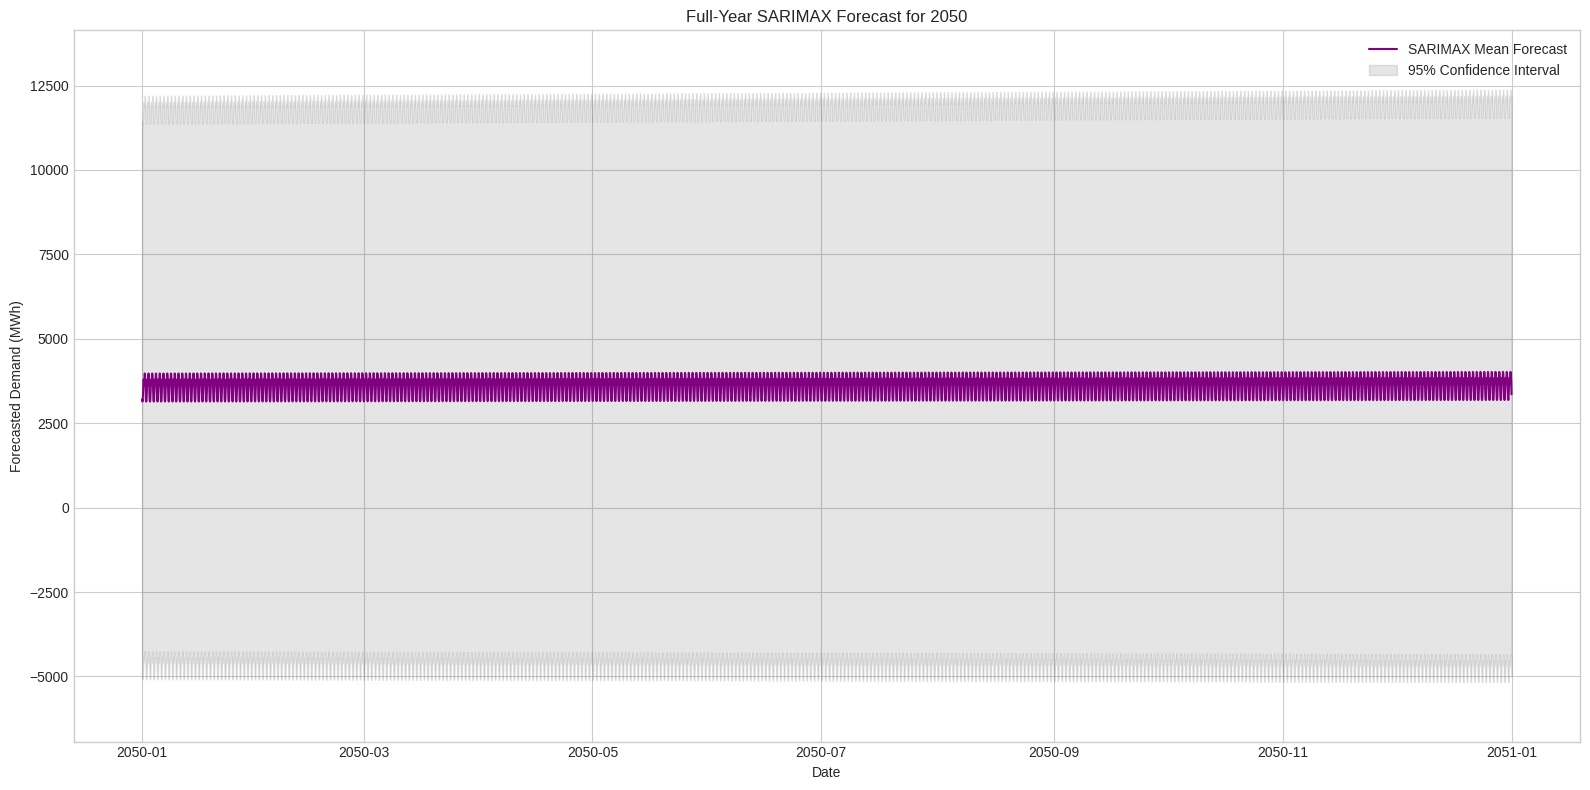

Full-year forecast for 2050 saved to SARIMAX_forecast_HRel2050.txt

--- ANALYSIS COMPLETE ---


In [8]:
# =============================================================================
# CELL 8: MEMORY-EFFICIENT LONG-TERM FORECASTING USING get_prediction
# =============================================================================
# To handle memory constraints with complex models, this version uses the
# get_prediction() method, which is more memory-efficient for fetching
# specific future time slices without generating the entire intermediate forecast.

if 'sarimax_model_for_long_term_forecast_fit' in globals() and sarimax_model_for_long_term_forecast_fit is not None:

    target_years = [2030, 2040, 2050]
    
    # Get the last date from the training data for reference
    full_data_clean = demand_2018_hourly.copy()
    if full_data_clean.isnull().any():
        full_data_clean.fillna(method='ffill', inplace=True)
        full_data_clean.fillna(method='bfill', inplace=True)
    
    print(f"\n--- GENERATING EFFICIENT LONG-TERM FORECASTS FOR: {target_years} ---")

    # Loop through each target year and generate a forecast for that specific year
    for year in target_years:
        print(f"\n--- Generating forecast for year: {year} ---")

        # 1. Define the start and end dates for the target year's forecast
        start_date = f'{year}-01-01 00:00:00'
        end_date = f'{year}-12-31 23:00:00'
        
        print(f"Requesting forecast slice from {start_date} to {end_date}.")
        
        try:
            # 2. Use get_prediction for this specific time range. This is highly memory-efficient.
            prediction_object = sarimax_model_for_long_term_forecast_fit.get_prediction(start=start_date, end=end_date)
            
            forecast_for_year = prediction_object.predicted_mean
            conf_int_for_year = prediction_object.conf_int(alpha=0.05)
            print("Yearly forecast slice generated successfully.")

            if forecast_for_year.empty:
                print(f"WARNING: No forecast data for year {year}.")
                continue
            
            print(f"Descriptive Statistics for {year} Forecast:")
            print(forecast_for_year.describe())

            # 3. Plot the results for the target year
            plt.figure(figsize=(16, 8))
            plt.plot(forecast_for_year.index, forecast_for_year, label=f'SARIMAX Mean Forecast', color='purple')
            plt.fill_between(conf_int_for_year.index,
                             conf_int_for_year.iloc[:, 0],
                             conf_int_for_year.iloc[:, 1],
                             color='k', alpha=0.1, label='95% Confidence Interval')
            
            min_val = conf_int_for_year.iloc[:, 0].min()
            max_val = conf_int_for_year.iloc[:, 1].max()
            buffer = (max_val - min_val) * 0.1
            plt.ylim(min_val - buffer, max_val + buffer)

            plt.title(f'Full-Year SARIMAX Forecast for {year}')
            plt.xlabel('Date')
            plt.ylabel('Forecasted Demand (MWh)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # 4. Save the forecast to a file
            filename_txt = f'SARIMAX_forecast_HRel{year}.txt'
            np.savetxt(filename_txt, forecast_for_year.values, fmt='%.2f')
            print(f"Full-year forecast for {year} saved to {filename_txt}")
                
            # 5. Clean up memory before the next loop iteration
            del prediction_object, forecast_for_year, conf_int_for_year
            gc.collect()

        except Exception as e:
            print(f"An unexpected error occurred during forecasting for year {year}: {e}")
            break

else:
    print("Final model was not successfully trained. Skipping long-term forecasting.")

print("\n--- ANALYSIS COMPLETE ---")